# 1. Tipos de fronteras en Clasificación

Primero, se generan los conjuntos de datos con los que se analizarán las distintas fronteras y algoritmos a utilizar

In [53]:
# Generacion de los datos para analisis
from sklearn.utils import check_random_state
import matplotlib.patches as mpatches
import numpy as np


def build_data(seed, noise_seed=64, n_samples=500, noise=20):
    n_samples=500
    mean = (0,-4)
    C = np.array([[0.3, 0.1], [0.1, 1.5]])
    np.random.seed(seed)
    datos1 = np.random.multivariate_normal(mean, C, n_samples)
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples))*3
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples))*3
    datos2 = np.vstack((outer_circ_x,outer_circ_y)).T

    generator = check_random_state(noise_seed)
    datos2 += generator.normal(scale=0.3, size=datos2.shape)

    X = np.concatenate((datos1, datos2), axis=0)
    n = noise #ruido/noise
    y1 = np.zeros(datos1.shape[0]+n)
    y2 = np.ones(datos2.shape[0]-n)
    y = np.concatenate((y1,y2),axis=0)
    return (X, y)

(X, y) = build_data(14)
(Xtest, ytest) = build_data(8000, noise_seed=7000)

A continuación, se visualizan brevemente los datos

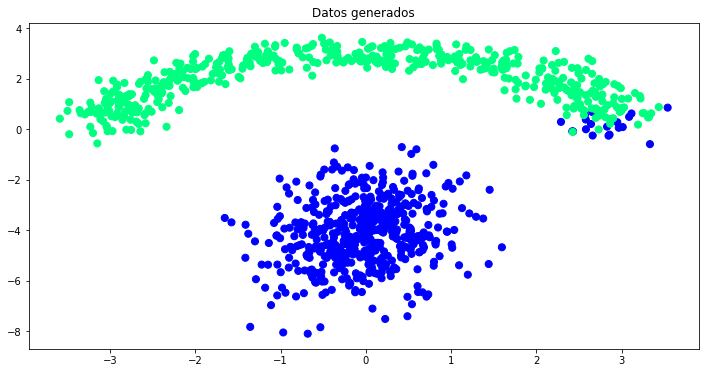

In [54]:
# Se grafican los datos obtenidos
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))
plt.scatter(X[:, 0], X[:,1], s=50, c=y, cmap=plt.cm.winter)
plt.title('Datos generados')
plt.show()

A continuación se define una función para visualizar la frontera que divide a los datos dado un modelo entrenado con el objeto de rápidamente ver los bordes de decisión encontrados por los distintos algoritmos


In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def visualize_border(model,x,y, title="", x_test=None, y_test=None):
    fig = plt.figure(figsize=(12,6))
    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = .02 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    if x_test is not None and y_test is not None:
        y_train_pred = model.predict(x)
        y_test_pred = model.predict(x_test)
        train_error = (1-accuracy_score(y, y_train_pred))
        test_error = (1-accuracy_score(y_test, y_test_pred))
        red_patch = mpatches.Patch(color='red', label="Train ME: %f" % train_error)
        green_patch = mpatches.Patch(color='green', label="Test ME: %f" % test_error)
        plt.legend(handles=[red_patch, green_patch])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title(title)
    plt.show()

### Linear Discriminant Analysis (LDA)

A continuación se entrena un modelo usando LDA. Este algoritmo asume que la función de densidad de cada clase es gaussiana y que además existe una matriz de covarianza $\Sigma$ igual entre las clases.

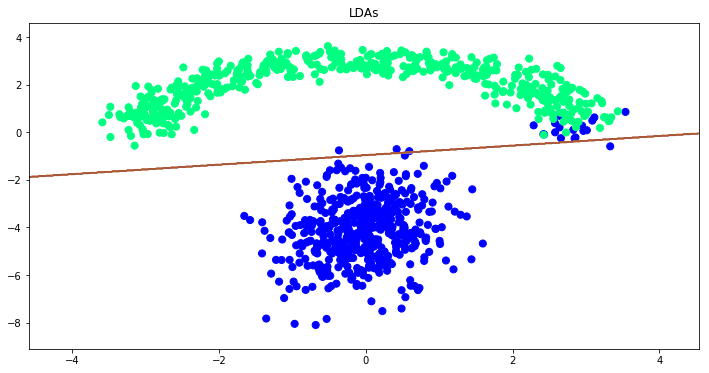

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model_LDA = LDA()
model_LDA.fit(X,y)
visualize_border(model_LDA,X,y,"LDAs")

Con un error de clasificación de entrenamiento igual a:

In [57]:
1-model_LDA.score(X, y)

0.02200000000000002

Y con un error de clasificación de testing igual a:

In [58]:
1-model_LDA.score(Xtest, ytest)

0.02300000000000002

### Quadratic Discriminant Analysis (QDA)

A continuación se entrena un modelo usando QDA. Este algoritmo, al igual que LDA, asume que la densidad de los datos siguen distribuciones gaussianas, buscando encontrar la frontera que maximice la distancia entre dos distribuciones. A diferencia de **LDA**, QDA no asume nada respecto a las matrices de covarianza de dichas distribuciones.

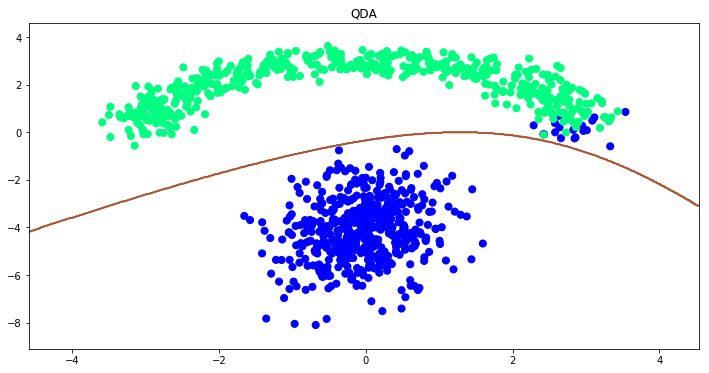

In [59]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
model_QDA = QDA()
model_QDA.fit(X,y)
visualize_border(model_QDA,X,y,"QDA")

Con un error de entrenamiento igual a:

In [60]:
1-model_QDA.score(X, y)

0.020000000000000018

Y un error de testing igual a:

In [61]:
(Xtest, ytest) = build_data(8000, noise_seed=7000)
1-model_LDA.score(Xtest, ytest)

0.02300000000000002

### QDA v/s LDA


##### Diferencia cualitativa y teórica

La principal diferencia entre QDA y LDA se puede visualizar en las secciones anteriores en donde se puede observar claramente que las fronteras calculadas por LDA son lineales, mientras que las de QDA y en honor a su nombre son cuadráticas.

##### Diferencia cuantitativa

A continuación se presentan los errores de clasificación para ambos modelos

In [62]:
from sklearn.metrics import accuracy_score

y_pred_LDA = model_LDA.predict(X)
y_pred_QDA = model_QDA.predict(X)
print("Miss Classification Loss for LDA: %f"%(1-accuracy_score(y, y_pred_LDA)))
print("Miss Classification Loss for QDA: %f"%(1-accuracy_score(y, y_pred_QDA)))

Miss Classification Loss for LDA: 0.022000
Miss Classification Loss for QDA: 0.020000


Se puede apreciar que, en este caso particular, es QDA el que tiene mejor rendimiento en comparación a LDA. Esto no sorprende debido a la naturaleza de la distribución de los datos que hacen a **QDA** un mejor estimador.

### Logistic Regression

La regresión logística es una forma de utilizar el concepto regresión lineal para clasificar datos según atributos dados. Esta función hace uso de la función Logit para transformar outputs numéricos a labels.

A continuación se define una función para graficar las fronteras seleccionadas por cada máquina permitiendo la interacción con distintos parámetros.

In [63]:
from ipywidgets import interactive
def visualize_border_interactive(param):
    model = train_model(param)
    visualize_border(model,X,y,x_test=Xtest,y_test=ytest)


Se entrena un modelo de regresión logística regularizado con la normal $l_2$ (Lasso)

In [64]:
from sklearn.linear_model import LogisticRegression as LR
def train_model(param):
    model=LR() #define your model
    model.set_params(C=param,penalty='l2')
    model.fit(X,y)
    return model

In [65]:
p_min_lr = 0.001
p_max_lr = 1
interactive(visualize_border_interactive,param=(p_min_lr,p_max_lr, 0.001))

interactive(children=(FloatSlider(value=0.5, description='param', max=1.0, min=0.001, step=0.001), Output()), _dom_classes=('widget-interact',))

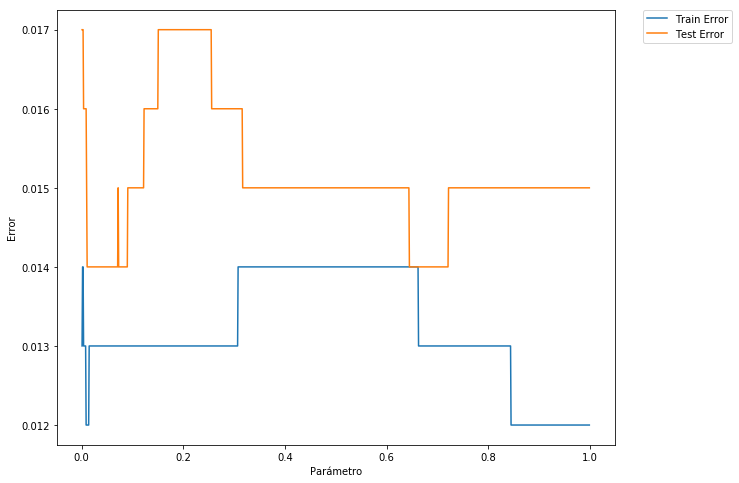

In [14]:
import numpy as np
import matplotlib.pyplot as plt
params = np.arange(0.001, 1.0, 0.001)

train_errors = []
test_errors = []

for p in params:
    model= LR()
    model.set_params(C=p,penalty='l2')
    model.fit(X,y)
    
    y_train_pred = model.predict(X)
    y_test_pred = model.predict(Xtest)
    train_error = (1-accuracy_score(y, y_train_pred))
    test_error = (1-accuracy_score(ytest, y_test_pred))
    
    train_errors.append(train_error)
    test_errors.append(test_error)
    
plt.figure(figsize=(10, 8))
plt.plot(params, train_errors, label="Train Error")
plt.plot(params, test_errors, label="Test Error")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Parámetro')
plt.ylabel('Error')
plt.show()

El parámetro $C$ es un parámetro de regularización que actua como el inverzo de la fuerza de regularización para la norma $l_2$ en donde valores cercanos a $1.0$ indican ausencia de regularización y valores cercanos a $0.0$ indican la máxima posible fuerza de regularización.

Cuando hay alta regularización, aumenta el número de outliers que son ignorados durante el entrenamiento.

### SVM Lineal

El método de SVM (Support Vector Machine) busca una frontera de decisión maximizando el margen entre las distintas clases o labels del conjunto de datos, procurando a la vez clasificar la mayor cantidad de datos en el conjunto de entrenamiento correctamente. Existe un hiperparámetro que mide el tradeoff entre la maximización del margen y el error de entrenamiento que es generalmente denotado por C

Se construye el siguiente gráfico con la frontera seleccionada por una SVM de tipo lineal

In [15]:
from sklearn.svm import SVC as SVM

def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='linear')
    model.fit(X,y)
    return model

p_min_svm_linear = 0.001
p_max_svm_linear = 1
interactive(visualize_border_interactive,param=(p_min_svm_linear,p_max_svm_linear, 0.001))

interactive(children=(FloatSlider(value=0.5, description='param', max=1.0, min=0.001, step=0.001), Output()), _dom_classes=('widget-interact',))

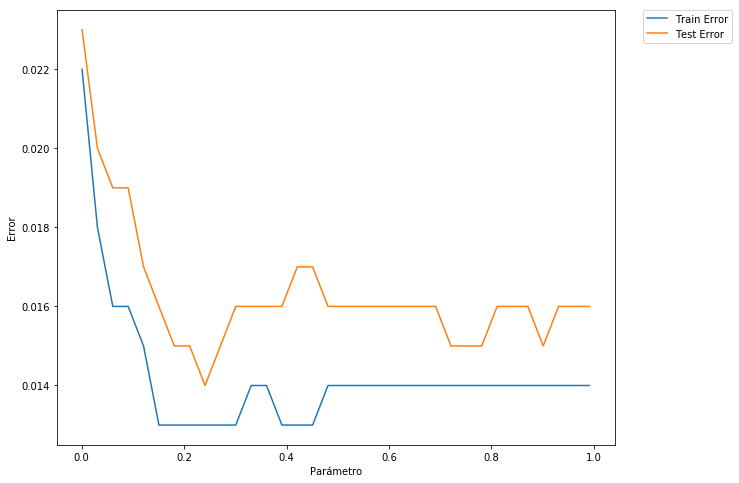

In [16]:
import numpy as np
import matplotlib.pyplot as plt
params = np.arange(0.001, 1.0, 0.03)

train_errors = []
test_errors = []

for p in params:
    model= SVM()
    model.set_params(C=p,kernel='linear')
    model.fit(X,y)
    
    y_train_pred = model.predict(X)
    y_test_pred = model.predict(Xtest)
    train_error = (1-accuracy_score(y, y_train_pred))
    test_error = (1-accuracy_score(ytest, y_test_pred))
    
    train_errors.append(train_error)
    test_errors.append(test_error)
    
plt.figure(figsize=(10, 8))
plt.plot(params, train_errors, label="Train Error")
plt.plot(params, test_errors, label="Test Error")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Parámetro')
plt.ylabel('Error')
plt.show()
    


De manera teórica, el parametro **$C$** en la SVM lineal controla el tradeoff entre maximizar el margen entre las dos clases y minimizar el error de clasificación del conjunto de entrenamiento (considerando una función objetivo dada por $CA+B$ y en dónde la constante está dada generalmente por $C = \frac{1}{\lambda}$). Si se utilizan valores de $C$ grandes, el modelo de SVM lineal intentará con más fuerza clasificar correctamente los puntos de entrenamiento, lo que disminuye la maximización del margen y lleva a posible overfitting.

Se puede observar en el gráfico interactivo que para un valor de $C$ cercano a 0, se tiene una frontera que clasifica menos puntos de la clase $AZUL$, mientras que valores cercanos a 1 consideran mayor puntos de la clase $AZUL$. Esto es esperado considerando el significado del parámetro $C$.

### SVM No lineal

En el método de SVM no lineal, se utilizan kernels que realizan transformaciones al espacio original de datos a nuevos espacios en donde sea posible tener fronteras linealmente separables. El ejemplo clásico es cuando la frontera es de tipo circular. En este caso, se necesita utilizar un método de kernel para llevar a un espacio lineal a los datos. En este caso, una transformación teórica podria ser $z = x^2 + y^2$ que transforma el espacio euclidiano original en un espacio de coordenadas poalres. Aquí, si es posible encontrar una frontera linealmente separable.

A continuación se exploran las fronteras de decisión de distintos kernels (por tanto, supuestos de transformaciones distintos) sujetos a distintos valores del parámetro C. Estos kernels producen fronteras que no son lineales en el espacio original de los datos.

##### Kernel de función radial base o Radial basis function (RBF)

In [67]:

from sklearn.svm import SVC as SVM #SVC is for classification
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='rbf')
    model.fit(X,y)
    return model

p_min_svm_rbf = 0.001
p_max_svm_rbf = 1
interactive(visualize_border_interactive,param=(p_min_svm_rbf,p_max_svm_rbf, 0.001))



interactive(children=(FloatSlider(value=0.5, description='param', max=1.0, min=0.001, step=0.001), Output()), _dom_classes=('widget-interact',))

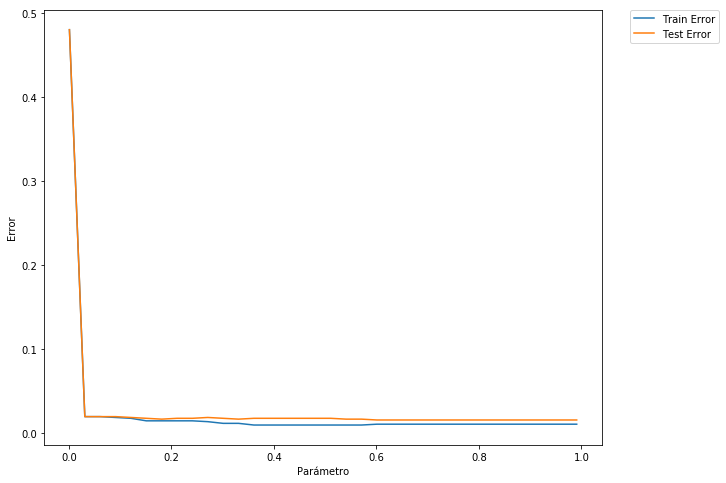

In [18]:
import matplotlib.pyplot as plt
params = np.arange(0.001, 1.0, 0.03)

train_errors = []
test_errors = []

for p in params:
    model= SVM()
    model.set_params(C=p,kernel='rbf')
    model.fit(X,y)
    
    y_train_pred = model.predict(X)
    y_test_pred = model.predict(Xtest)
    train_error = (1-accuracy_score(y, y_train_pred))
    test_error = (1-accuracy_score(ytest, y_test_pred))
    
    train_errors.append(train_error)
    test_errors.append(test_error)
    
plt.figure(figsize=(10, 8))
plt.plot(params, train_errors, label="Train Error")
plt.plot(params, test_errors, label="Test Error")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Parámetro')
plt.ylabel('Error')
plt.show()

Se puede notar que con este kernel se pueden obtener bajos errores de clasificación debido a que la naturaleza de **RBF** permite envolver correctamente al conjunto sinusoidal de datos, generando una frontera ideal

##### Kernel polinomial

In [68]:
from sklearn.svm import SVC as SVM #SVC is for classification
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='poly')
    model.fit(X,y)
    return model

p_min_svm_poly = 0.001
p_max_svm_poly = 1
interactive(visualize_border_interactive,param=(p_min_svm_poly,p_max_svm_poly, 0.001))

interactive(children=(FloatSlider(value=0.5, description='param', max=1.0, min=0.001, step=0.001), Output()), _dom_classes=('widget-interact',))

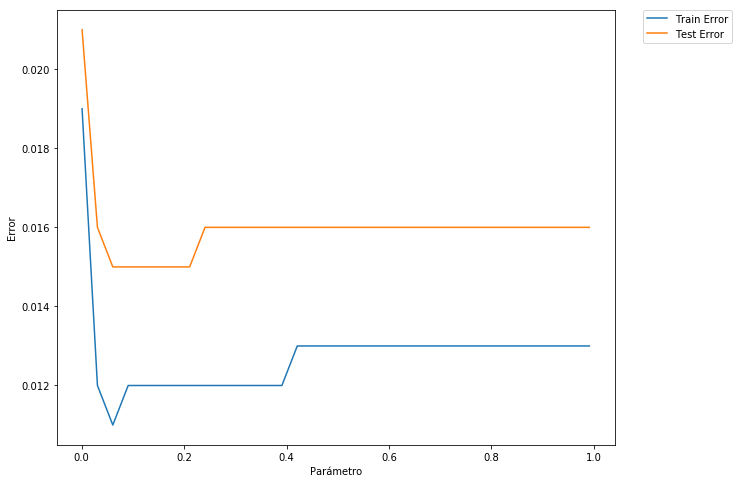

In [20]:
import matplotlib.pyplot as plt
params = np.arange(0.001, 1.0, 0.03)

train_errors = []
test_errors = []

for p in params:
    model= SVM()
    model.set_params(C=p,kernel='poly')
    model.fit(X,y)
    
    y_train_pred = model.predict(X)
    y_test_pred = model.predict(Xtest)
    train_error = (1-accuracy_score(y, y_train_pred))
    test_error = (1-accuracy_score(ytest, y_test_pred))
    
    train_errors.append(train_error)
    test_errors.append(test_error)
    
plt.figure(figsize=(10, 8))
plt.plot(params, train_errors, label="Train Error")
plt.plot(params, test_errors, label="Test Error")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Parámetro')
plt.ylabel('Error')
plt.show()

Este kernel no funciona tan bien en comparación a **RBF** debido a la naturaleza de la distribución de los datos, por lo que presenta un error de testing mayor

#### Kernel sigmoidal

Este kernel se basa en la función sigmoidal y asume dicha distribución de los datos

In [21]:
from sklearn.svm import SVC as SVM #SVC is for classification
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='sigmoid')
    model.fit(X,y)
    return model

p_min_svm_sigmoid = 0.001
p_max_svm_sigmoid = 1
interactive(visualize_border_interactive,param=(p_min_svm_sigmoid,p_max_svm_sigmoid))

interactive(children=(FloatSlider(value=0.5005, description='param', max=1.0, min=0.001), Output()), _dom_classes=('widget-interact',))

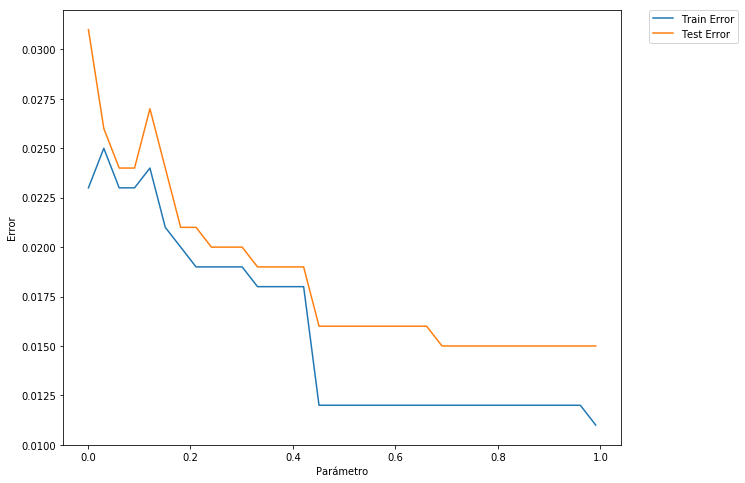

In [22]:
import matplotlib.pyplot as plt
params = np.arange(0.001, 1.0, 0.03)

train_errors = []
test_errors = []

for p in params:
    model= SVM()
    model.set_params(C=p,kernel='sigmoid')
    model.fit(X,y)
    
    y_train_pred = model.predict(X)
    y_test_pred = model.predict(Xtest)
    train_error = (1-accuracy_score(y, y_train_pred))
    test_error = (1-accuracy_score(ytest, y_test_pred))
    
    train_errors.append(train_error)
    test_errors.append(test_error)
    
plt.figure(figsize=(10, 8))
plt.plot(params, train_errors, label="Train Error")
plt.plot(params, test_errors, label="Test Error")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Parámetro')
plt.ylabel('Error')
plt.show()

Como es de esperarse, este kernel no se comporta lo suficientemente bien en comparación a **RBF** debido a que la forma de las fronteras no es sigmoidal. Además, requiere de altos valores de $C$ para lograr errores pequeños lo que posiblemente indica overfitting del conjunto de datos

### Árbol de decisión

Los árboles de decisión dividen el espacio de los atributos en subconjuntos con el fin de utilizar la heurística de dividir y conquistar, que es ampliamente utilizada en la cienca de la computación. Cada subespacio en el árbol contendrá la clase más probable dentro de una misma sección.

El hiperparámetro de este modelo corresponde al a profundidad del árbol que corresponde la número máximo de subcortes posibles del espacio original

In [23]:
from sklearn.tree import DecisionTreeClassifier as Tree

def train_model(param):
    model = Tree() #edit the train_model function
    model.set_params(max_depth=param,criterion='gini',splitter='best')
    model.fit(X,y)
    return model

p_tree_min = 1
p_tree_max = 10
interactive(visualize_border_interactive,param=(p_tree_min,p_tree_max))


interactive(children=(IntSlider(value=5, description='param', max=10, min=1), Output()), _dom_classes=('widget-interact',))

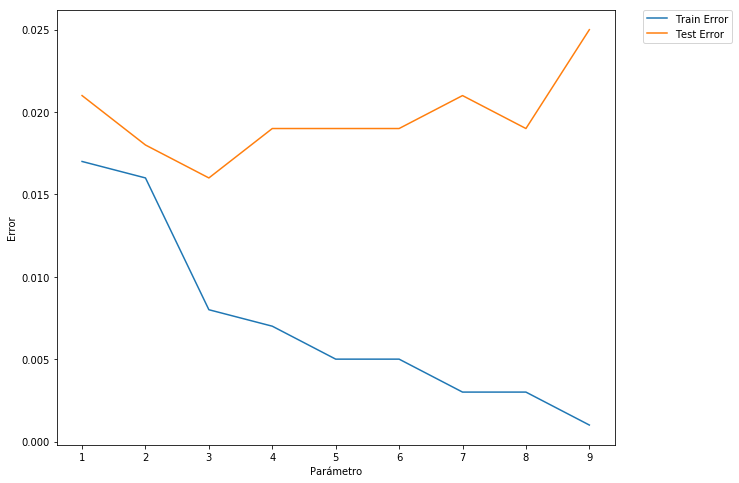

In [24]:
import matplotlib.pyplot as plt
params = np.arange(1, 10, 1)

train_errors = []
test_errors = []

for p in params:
    model= Tree()
    model.set_params(max_depth=p,criterion='gini',splitter='best')
    model.fit(X,y)
    
    y_train_pred = model.predict(X)
    y_test_pred = model.predict(Xtest)
    train_error = (1-accuracy_score(y, y_train_pred))
    test_error = (1-accuracy_score(ytest, y_test_pred))
    
    train_errors.append(train_error)
    test_errors.append(test_error)
    
plt.figure(figsize=(10, 8))
plt.plot(params, train_errors, label="Train Error")
plt.plot(params, test_errors, label="Test Error")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Parámetro')
plt.ylabel('Error')
plt.show()

Se puede notar que es muy fácil que el árbol de decisión caiga en overfitting. En efecto, la profundidad óptima está entre 3 y 4, y valores mayores a estos manifiestan el efecto de overfitting

### Clasificador de K-vecinos más cercano

Este modelo utiliza los k-vecinos más similares de cada dato de entrenamiento para calcular la frontera de decisión. Su parámetro corresponde al número de vecinos $K$.

Cuando $K$ es muy pequeño, restringimos la región de comparación haciendo que nuestro clsificador sea más "ciego" a la distribución global de los datos. Este valor pequeño conducirá a overfitting.

Cuando $K$ es grande, el clasificador se hace más resistente a outliers, pero se hará más propenso a underfitting

In [25]:
from sklearn.neighbors import KNeighborsClassifier

def train_model(param):
    model = KNeighborsClassifier()
    model.set_params(n_neighbors=param)
    model.fit(X,y)
    return model

p_tree_min = 1
p_tree_max = 50
interactive(visualize_border_interactive,param=(p_tree_min,p_tree_max))


interactive(children=(IntSlider(value=25, description='param', max=50, min=1), Output()), _dom_classes=('widget-interact',))

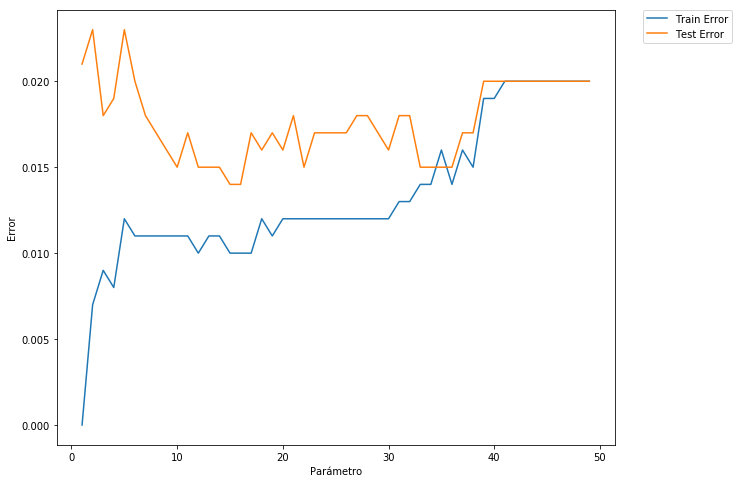

In [26]:
import matplotlib.pyplot as plt
params = np.arange(1, 50, 1)

train_errors = []
test_errors = []

for p in params:
    model = KNeighborsClassifier()
    model.set_params(n_neighbors=p)
    model.fit(X,y)
    
    y_train_pred = model.predict(X)
    y_test_pred = model.predict(Xtest)
    train_error = (1-accuracy_score(y, y_train_pred))
    test_error = (1-accuracy_score(ytest, y_test_pred))
    
    train_errors.append(train_error)
    test_errors.append(test_error)
    
plt.figure(figsize=(10, 8))
plt.plot(params, train_errors, label="Train Error")
plt.plot(params, test_errors, label="Test Error")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Parámetro')
plt.ylabel('Error')
plt.show()

Como es esperado, se tiene que a valores muy bajos se produce overfitting de los datos y que valores muy altos producirán el underfitting esperado